In [1]:
from pyspark.sql import functions as F
from modules.spark import spark

In [2]:
df = spark.read.csv('../data/processed/data-with-relevant-columns.csv', header=True, inferSchema=True)

In [3]:
df.printSchema()

root
 |-- Type: string (nullable = true)
 |-- ShippingMode: string (nullable = true)
 |-- LateDeliveryRisk: integer (nullable = true)
 |-- CategoryName: string (nullable = true)
 |-- CustomerSegment: string (nullable = true)
 |-- OrderItemTotal: double (nullable = true)
 |-- OrderRegion: string (nullable = true)
 |-- ShippingMonthName: string (nullable = true)



### Visualiser les données.

In [4]:
pdf = df.toPandas()

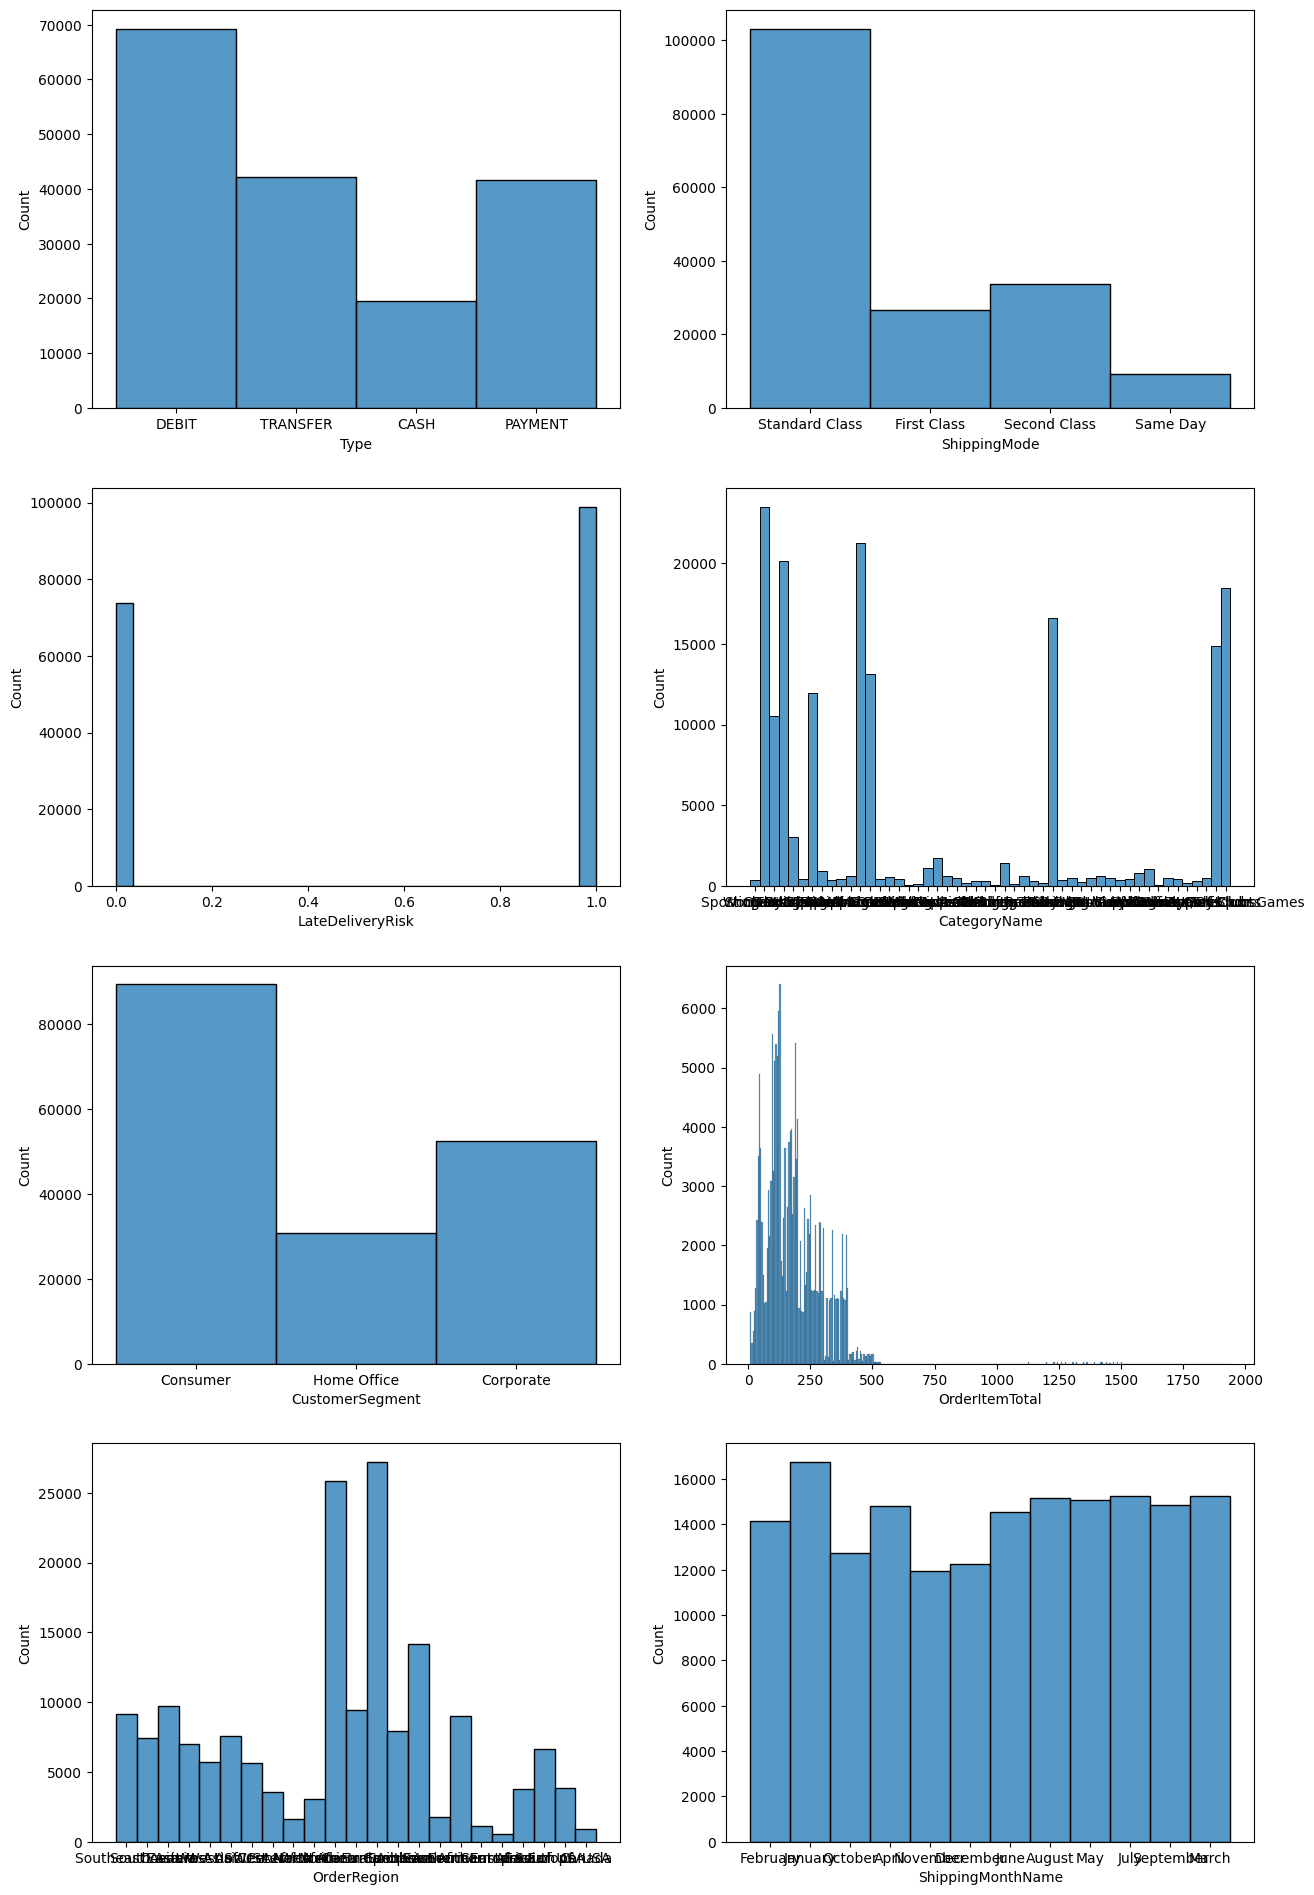

In [5]:
import matplotlib.pyplot as plt
import seaborn as sb

i = 1
plt.figure(figsize=(15, 30))

for col in pdf.columns:
    plt.subplot(5, 2, i)
    sb.histplot(data=pdf, x=col)

    i += 1

plt.show()

### Analyser les statistiques.

In [6]:
df.select("OrderItemTotal").describe().show()

+-------+------------------+
|summary|    OrderItemTotal|
+-------+------------------+
|  count|            172765|
|   mean|  183.165948403594|
| stddev|120.14187134623965|
|    min|       7.489999771|
|    max|        1939.98999|
+-------+------------------+



In [7]:
for col in ["Type", "ShippingMode", "LateDeliveryRisk", "CategoryName", "CustomerSegment", "OrderRegion", "ShippingMonthName"]:
    print(col)
    df.groupBy(col).count().orderBy(F.col("count").desc()).show()

Type
+--------+-----+
|    Type|count|
+--------+-----+
|   DEBIT|69295|
|TRANSFER|42129|
| PAYMENT|41725|
|    CASH|19616|
+--------+-----+

ShippingMode
+--------------+------+
|  ShippingMode| count|
+--------------+------+
|Standard Class|103153|
|  Second Class| 33806|
|   First Class| 26513|
|      Same Day|  9293|
+--------------+------+

LateDeliveryRisk
+----------------+-----+
|LateDeliveryRisk|count|
+----------------+-----+
|               1|98977|
|               0|73788|
+----------------+-----+

CategoryName
+--------------------+-----+
|        CategoryName|count|
+--------------------+-----+
|              Cleats|23514|
|      Men's Footwear|21263|
|     Women's Apparel|20116|
|Indoor/Outdoor Games|18470|
|             Fishing|16595|
|        Water Sports|14880|
|    Camping & Hiking|13157|
|    Cardio Equipment|11948|
|       Shop By Sport|10515|
|         Electronics| 3024|
|         Accessories| 1697|
|          Golf Balls| 1403|
|      Girls' Apparel| 1137|
|      

In [8]:
# Approximate quantiles: faster and scalable
quantiles = df.approxQuantile("OrderItemTotal", [0.25, 0.75], 0.0)
Q1, Q3 = quantiles
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_outliers = df.withColumn(
    "is_outlier",
    F.when((F.col("OrderItemTotal") < lower_bound) | (F.col("OrderItemTotal") > upper_bound), 1).otherwise(0)
)

- Number of outliers

In [9]:
df_outliers.filter(F.col('is_outlier') == 1).count()

1853

- Remove outliers

In [10]:
df_cleaned = df_outliers.filter(F.col('is_outlier') == 0).drop('is_outlier')

In [11]:
df_cleaned.count()

170912

- Sauvegardez les données

In [14]:
df_cleaned.write.csv('../data/processed/data-cleaned', header=True)